## Introdução

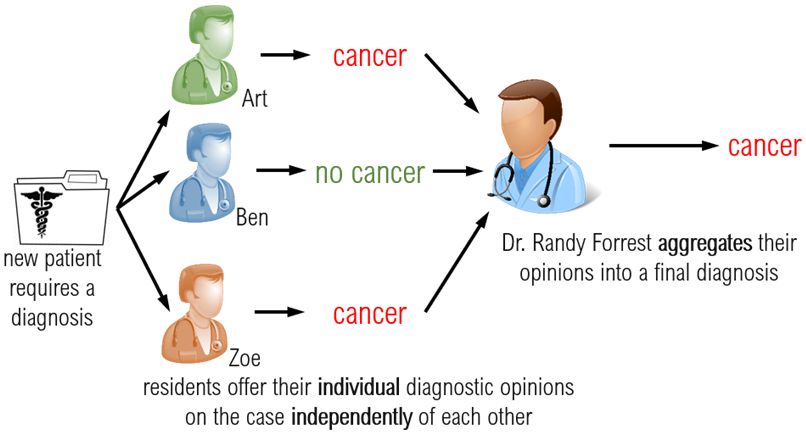

Dr. Forrest faz uma fusão (ensemble) de diagnósticos: ele agrega os diagnósticos de seus residentes em único diagnóstico que representa o conhecimento coletivo de seu time. Com essa abordagem, o Dr. Forrest acerta com mais frequência do que qualquer um dos seus residentes individualmente.

Por que? Porque ele sabe que seus residentes são inteligentes e que é improvável que um grande número deles cometa os mesmos erros. Especialmente considerando que eles possuem diferentes especialidades (diversidade de opiniões). O Dr. Forrest então confia no poder da agregação de decisões: ele sabe que a média ou moda das respostas muito provavelmente será a correta.

Aqui, o Dr. Randy Forrest seria o método de ensemble e seus residentes (que estão em treinamento) seriam os algoritmos de aprendizagem que compõe o ensemble. Os segredos de seu sucesso, assim como o de métodos baseados em ensemble, são:


*   diversidade, há uma variedade de opiniões para escolher, e
*   agregação, ele pode combiná-las em uma decisão final.

Qualquer coleção de algoritmos de aprendizagem de máquina pode ser usada para construir ensembles. Por que ensembles funcionam? James Surowiecki, no livro The Wisdom of Crowds, descreve o princípio por meio da descrição de ensembles humanos:

*“If you ask a large enough group of diverse and independent people to make a prediction or estimate a probability, the average of those answers will cancel out errors in individual estimation. Each person's guess, you might say, has two components: information and errors. Subtract the errors, and you're left with the information.”*

#### Definição de Ensemble

Um método de ensemble é um algoritmo de aprendizagem de máquina cujo objetivo é melhorar o desempenho preditivo em uma tarefa, agregando as previsões de múltiplos estimadores ou modelos. Dessa maneira, um método de ensemble aprende um meta-modelo.


## Desempenho de Métodos Baseados em Ensembles

In 2018, Olson et al 3 conduziu uma ampla análise de 13 algoritmos populares de aprendizagem de máquina e suas variantes. Eles ranquearam o desempenho de cada algoritmo em 165 conjuntos de dados. A Figura abaixo mostra o resultado.

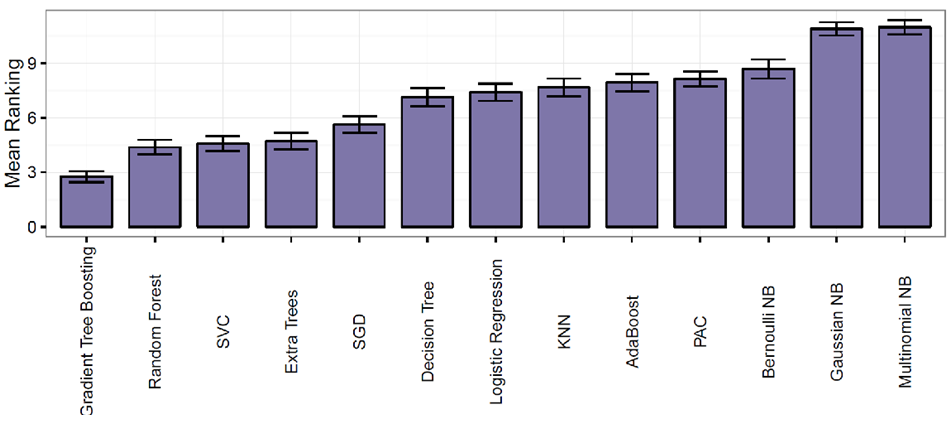


# Trade-off Bias Variância - Revisão

In [ ]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
X, y = load_boston(return_X_y=True)

X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

import numpy as np

subsets = ShuffleSplit(n_splits=5, test_size=0.33, random_state=23)

model = DecisionTreeRegressor()
trn_scores, tst_scores = validation_curve(model, X, y, param_name='max_depth', param_range=range(1,11), cv=subsets, scoring='r2')
mean_train_score = np.mean(trn_scores, axis=1)
mean_test_score = np.mean(tst_scores, axis=1)

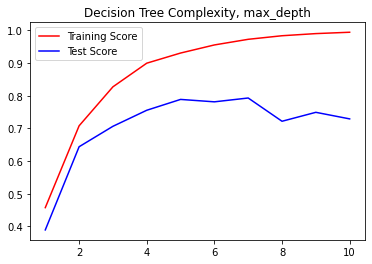

<Figure size 432x288 with 0 Axes>

In [ ]:
trn_scores

plt.plot(range(1,11), mean_train_score, 'r', label='Training Score')
plt.plot(range(1,11), mean_test_score, 'b', label='Test Score')
plt.title('Decision Tree Complexity, max_depth')
plt.legend(loc=0)
plt.figure()

plt.show()

# Nosso Primeiro Ensemble

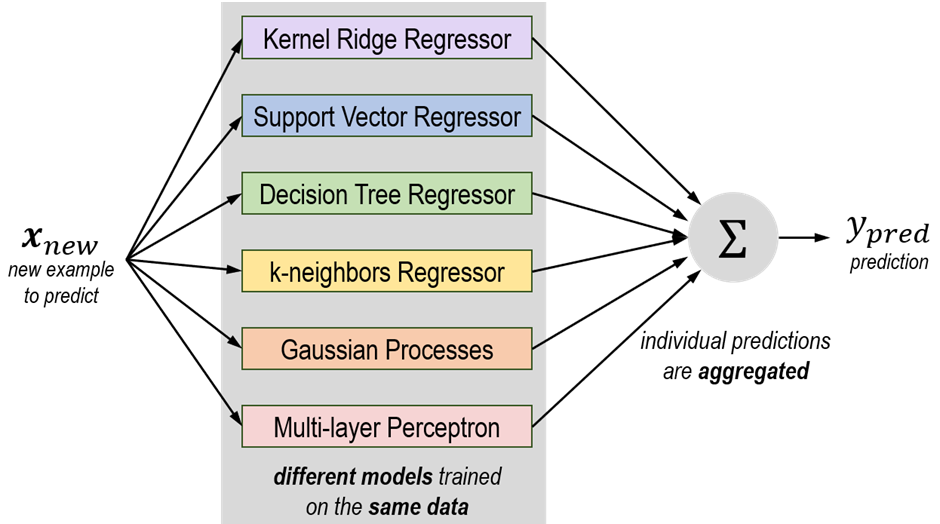

In [ ]:
Xtrn, Xtst, ytrn, ytst = train_test_split(X,y, test_size=0.33)

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

estimators = {'krr': KernelRidge(kernel='rbf', gamma=0.1),
              'svr': SVR(gamma=0.1),
              'dtr': DecisionTreeRegressor(max_depth=8),
              'knn': KNeighborsRegressor(n_neighbors=3),
              'gpr': GaussianProcessRegressor(alpha=1e-1),
              'mlp': MLPRegressor(alpha=25, max_iter=1000)}
for name, estimator in estimators.items():
  estimator = estimator.fit(Xtrn, ytrn.ravel())

In [ ]:
n_estimators, n_samples = len(estimators), Xtst.shape[0]
y_individual = np.zeros((n_samples, n_estimators))
for i, (model, estimator) in enumerate(estimators.items()):
  y_individual[:,i] = estimator.predict(Xtst)
y_final = np.mean(y_individual, axis=1)

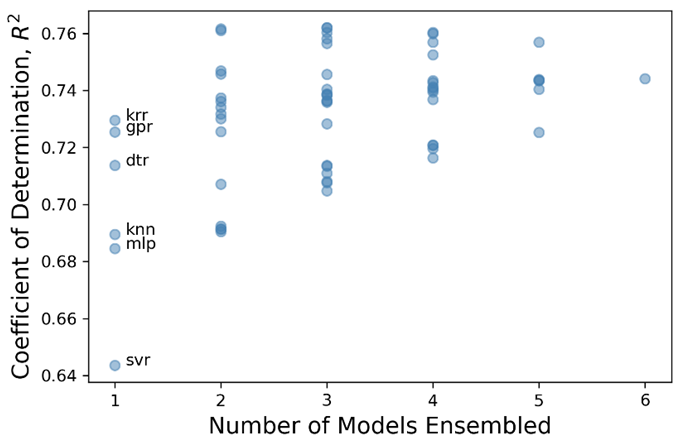


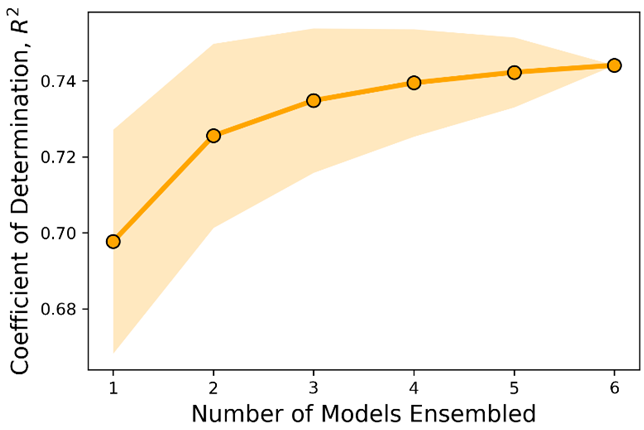
---



# Ensembles Paralelos

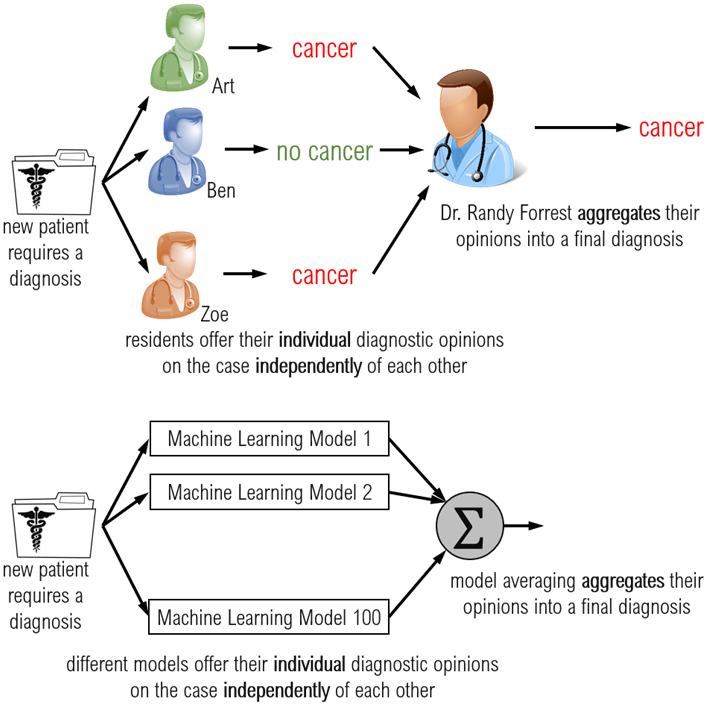

1.   Como criar um conjunto de estimadores base com "opiniões diversas" a partir de um único conjunto de dados?
2.   Como agregar decisões, ou predições, de cada estimador base individual em uma previsão final?

# Bagging: Bootstrap Aggregating

Bagging usa o mesmo tipo de modelo para treinar os estimadores base. Diversidade é alcançada treinando-se cada estimador base em uma amostra (diferente) dos dados originais.

A amostragem é com repetição (Bootstrap). Isso implica que cada amostra vai conter instâncias que estão presentes nos dados originais e instâncias nos dados originais que não foram amostradas (Out-of-Bag Sample - OOB). As instâncias OOB podem ser usadas como conjunto de validação.

A amostragem com repetição tende a conter 63.2% dos dados originais e 36.8% de instâncias OOB.

A fase de agregação é normalmente feita pelo voto majoritário (moda) para classificação e média para regressão, embora outras formas mais sofisticadas possam ser usadas (e.g., média ponderada e até outros modelos de ML).

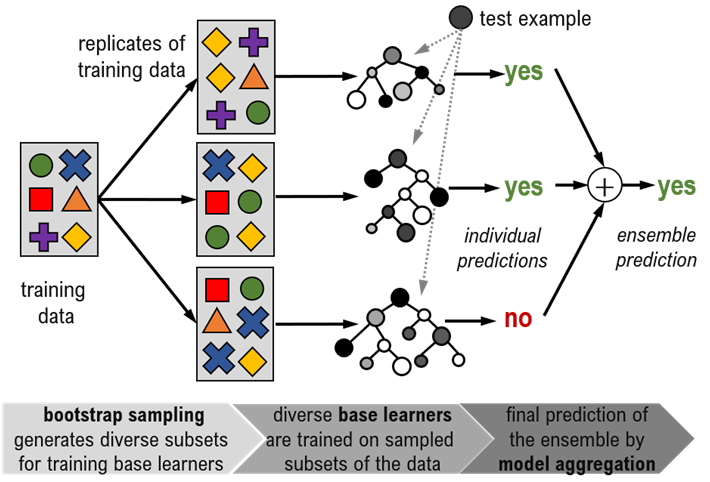

## Implementando Bagging

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def bagging_fit(X,y,n_estimators, max_depth=5,max_samples=200):
  n_examples = len(y)
  estimators = [DecisionTreeClassifier(max_depth=max_depth) for _ in range(n_estimators)]
  for tree in estimators:
    bag = np.random.choice(n_examples, max_samples, replace=True)
    tree.fit(X[bag,:],y[bag])
  return estimators

In [ ]:
from scipy.stats import mode

def bagging_predict(X,estimators):
  all_predictions = np.array([tree.predict(X) for tree in estimators])
  ypred, _ = mode(all_predictions, axis=0)
  return np.squeeze(ypred)

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X,y = make_moons(n_samples=300,noise=.25, random_state=0)
Xtrn, Xtst, ytrn, ytst = train_test_split(X,y, test_size=0.33)
bag_ens = bagging_fit(Xtrn,ytrn, n_estimators=500, max_depth=12, max_samples=200)
ypred = bagging_predict(Xtst,bag_ens)
accuracy_score(ytst,ypred)

0.9595959595959596

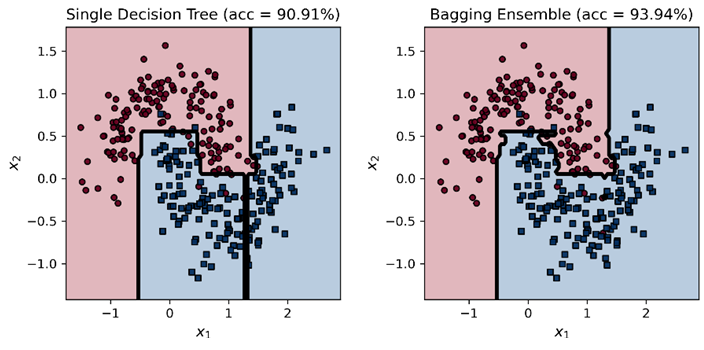

## Bagging com scikit-learn

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

base_estimator = DecisionTreeClassifier(max_depth=10)
bag_ens = BaggingClassifier(base_estimator=base_estimator,n_estimators=500,max_samples=100,oob_score=True)
bag_ens.fit(Xtrn,ytrn)
ypred = bag_ens.predict(Xtst)

In [ ]:
bag_ens.oob_score_

0.9402985074626866

In [ ]:
accuracy_score(ytst,ypred)

0.9494949494949495

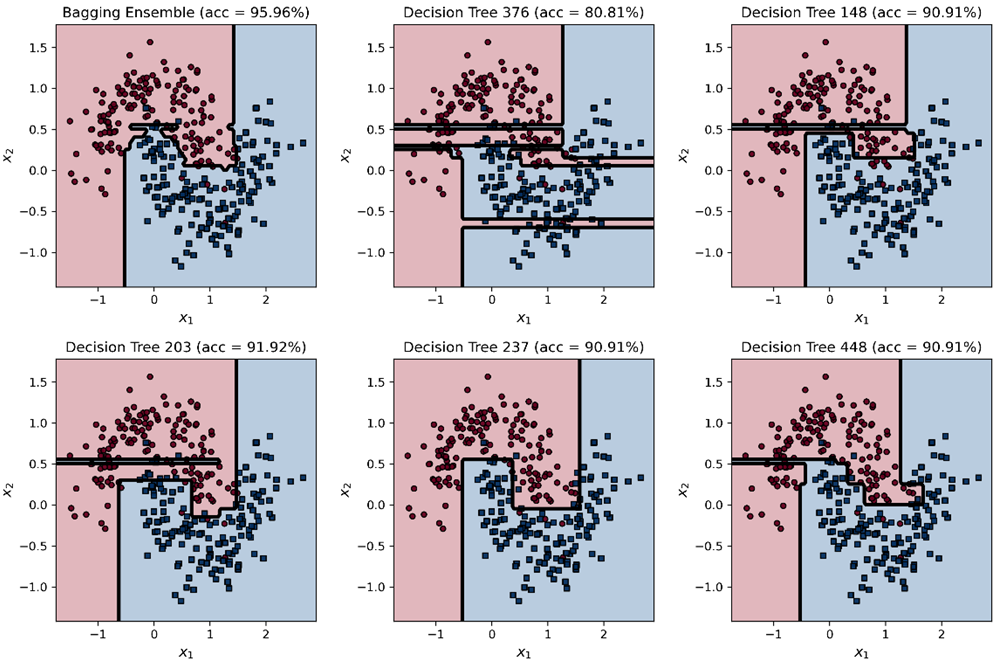

## Paralelizando o treino

In [ ]:
bag_ens = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100,max_samples=100,oob_score=True, n_jobs=-1)

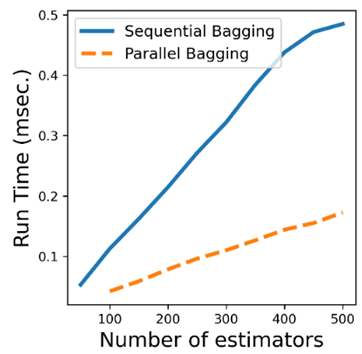

# Random Forests

Florestas aleatórias (Random Forests) são uma extensão de Bagging com as seguintes características:


*   Um subconjunto de instâncias é amostrado com repetição (Boostrap);
*   Um subconjunto de features também é amostrado antes do treinamento dos modelos base;
*   Os modelos base são necessariamente árvores de decisão.




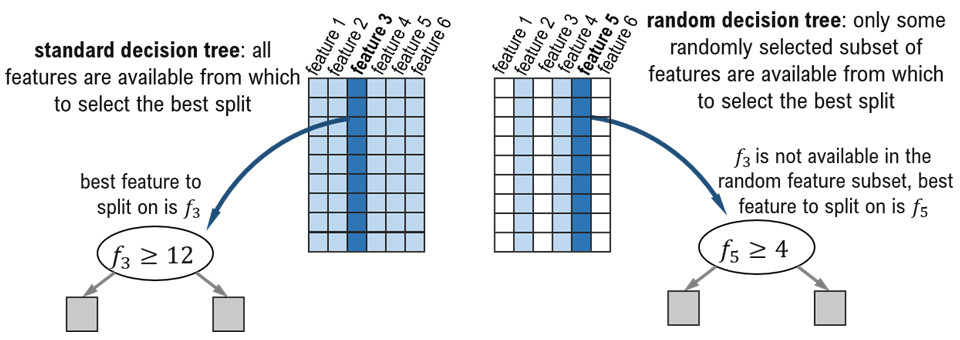

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_ens = RandomForestClassifier(n_estimators=500,max_depth=10,oob_score=True,n_jobs=-1)
rf_ens.fit(Xtrn,ytrn)
ypred = rf_ens.predict(Xtst)

In [ ]:
accuracy_score(ytst,ypred)

0.9494949494949495

## Importância das Features

Random forests também oferecem uma forma simples e robusta de calcular a importância das features. Uma das formas, chamada de *Mean Decrease Impurity*, essencialmente calcula a média das impurezas (calculadas via Gini ou Entropia) para cada atributo (ou nó) considerando todas as árvores da floresta aleatória. O segunite post traz mais detalhes sobre esse tópico: http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

In [ ]:
for i, score in enumerate(rf_ens.feature_importances_):
  print('Feature x{0}: {1:6.5f}'.format(i,score))

Feature x0: 0.51062
Feature x1: 0.48938


# ExtraTrees - Extremely Randomized Trees

> Bloco com recuo



Além de randomizar os conjuntos de dados e as features, esse método também randomiza o limiar de particção das features (numéricas). Esse método costuma ser tão eficaz que dispensa Bootstrap.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

ext_ens = ExtraTreesClassifier(n_estimators=500,max_depth=10,n_jobs=-1)
ext_ens.fit(Xtrn,ytrn)
ypred = ext_ens.predict(Xtst)

In [ ]:
accuracy_score(ytst,ypred)

0.9595959595959596

# Referências

[Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning) - Gautam Kunapuli. ISBN 9781617297137